In [80]:
#-- Importing modules
import flopy
import numpy as np
import pandas as pd
import flopy.modflow as fpm
import flopy.utils as fpu

In [81]:
#--importing data file
import csv

with open('coord.txt', newline='') as csvfile:
    data = list(csv.reader(csvfile))

print(data)

[['x', 'y'], [' 1', '1537.3919', '6482.2855'], [' 2', '1619.4925', '5350.2436'], [' 3', '1189.2087', '4426.7064'], [' 4', '1610.6249', '3517.6656'], [' 5', '95.2641', '2598.2555'], [' 6', '1800.4278', '2359.5935'], [' 7', '78.0893', '1727.8779'], ['8', '1708.18', '1586.7347'], [' 9', '115.4608', '581.3898'], [' 10', '1348.1983', '475.2261'], [' 11', '1909.8702', '-185.123'], [' 12', '1627.0996', '6571.9932'], [' 13', '1709.2002', '5439.9513'], [' 14', '1437.9059', '564.9337'], [' 15', '1537.3919', '6571.9932'], []]


In [82]:
#-- Defining boundries for DIS package
Lx = 1000
Ly = 1000
nrow = 100
ncol = 100
top = np.ones((nrow,ncol))
botm = np.zeros((nrow,ncol))
nlay = 1
delr = Ly / ncol
delc = Lx / nrow
delv = (top - botm) / nlay
perlen = 20

In [83]:
#--Generating model name
model_name = 'Draft_SP'
mf = flopy.modflow.Modflow(model_name, exe_name='mf2005')

In [84]:
disc = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm = botm, perlen = perlen, nstp = 1)

In [85]:
#--Output Control
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

In [86]:
#--BCF File
laycon = 0 #confined
tran = 1.0 
bcf = flopy.modflow.mfbcf.ModflowBcf(mf, laycon = 0, tran = 1)

In [87]:
#--Defining Head Boundary Conditions
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [88]:
#-- PCG File
pcg = flopy.modflow.mfpcg.ModflowPcg(mf, mxiter = 20, iter1 = 30)

In [106]:
#chd
#[layer, row, column, shead, ehead]

chd = 10
chd_data = []
for c in range(99):
    dd = np.array([0, 0, c, chd, chd])
    chd_data.append(dd)
for c in range(100):
    dd = np.array([0, c, 99, chd, chd])
    chd_data.append(dd)
for c in range(99):
    dd = np.array([0, 99, c, chd, chd])
    chd_data.append(dd)
for c in range(1, 99):
    dd = np.array([0, c, 0, chd, chd])
    chd_data.append(dd)
stress_period_data = {0:chd_data}
#stress_period_data

In [90]:
#-- Defining Recharge and Well Package
injection_rate = 0.1
wel = [[0, 152, 647, injection_rate], [0, 160, 534, injection_rate], [0, 117, 441, injection_rate], 
       [0, 159, 350, injection_rate], [0, 94, 258, injection_rate], [0, 179, 234, injection_rate], [0, 6, 171, injection_rate],
      [0, 169, 157, injection_rate], [0, 114, 580, injection_rate], [0, 133, 474, injection_rate], [0, 189, 184, injection_rate],
      [0, 161, 656, injection_rate]]
stress_period_data = {0 :wel}

In [91]:
#-- Linkag with mt3d
lmt = flopy.modflow.ModflowLmt(mf, output_file_name = 'mt3d_link.ftl')

In [92]:
#--Writing Input Files
mf.write_input()
#--And to run the model
mf.run_model()

FloPy is using the following  executable to run the model: C:\WRDAPP\mf2005.1\bin\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Draft_SP.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/08/20 19:54:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/08/20 19:54:02
 Elapsed run time:  0.146 Seconds

  Normal termination of simulation


(True, [])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Attempting to set identical left == right == 5.0 results in singular transformations; automatically expanding.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Attempting to set identical bottom == top == 995.0 results in singular transformations; automatically expanding.


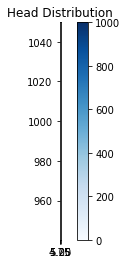

In [111]:
#To Plot Model Reults
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#To creat the headfile object
headobj = bf.HeadFile(model_name + '.hds')
head = headobj.get_data(totim = 20)
times = headobj.get_times()

#To setup contour Parameters
levels = np.arange(0, 1000, 5)
extent = (delr/2, delc/2, Lx - delc/2, Ly - delr/2)

#To make the plots
plt.subplot(1,1,1, aspect = 'equal')
plt.title('Head Distribution')
plt.imshow(head[0,:, :], extent = extent, cmap = 'Blues', vmin = 0, vmax = 1000)
plt.colorbar()

contours = plt.contour(np.flipud(head[0, :, :]), levels = levels, extent = extent, zorder = 10)
plt.clabel(contours, inline = 1, fontsize = 10, fmt = '%d')
plt.show()